In [1]:
using LinearAlgebra
using Plots
using SparseArrays
using Arpack #Eigenvalues of sparse arrays with eigs()
using DifferentialEquations
using DiffEqFlux
using Optim
using ForwardDiff
using DelimitedFiles

In [307]:
#Def parameters
n_cutoff = 8
N = 2 * n_cutoff + 1
NHilbert = N^2
n = sparse(Diagonal(LinRange(-n_cutoff, n_cutoff, N))) #Perhaps implement using StaticArrays
Id = sparse(I, N, N)
exp_iPhi = spdiagm(-1 => ones(N - 1));

#Def Hamiltonian parameters
E_J_GHz = 10.0 #scale of E_J in units of h*GHz, h-bar = 1, h = 2pi
E_C = 1/100  #Charging energies
E_J = 1.0 #Josephson energies
phi_ext = 0.995pi - da

prefactor = 4 * E_C
Kinetic = 2pi * E_J_GHz * prefactor * (kron(n^2, Id) .+ kron(Id, n^2))

Potential1 = -2pi * E_J_GHz * kron(1 / 2 * (exp_iPhi .+ exp_iPhi'), Id) # -E_J1 cos(phi1)
Potential2 = -2pi * E_J_GHz * kron(Id, 1 / 2 * (exp_iPhi .+ exp_iPhi')) # -E_J2 cos(phi2)
Pot3Mat = kron(exp_iPhi, exp_iPhi')
Pot3Const = -2pi * E_J_GHz * E_J / 2

function get_Pot3(Φ_ext = phi_ext)
    M = exp(im * Φ_ext) * Pot3Mat
    return Pot3Const * (M + M')
end

function dPot3_dphi(Φ_ext = phi_ext)
    M = exp(im * Φ_ext) * Pot3Mat
    return (im * Pot3Const) .* (M - M')
end

Potential3 =  get_Pot3() #-E_J3 cos(phi1 - phi2 + phi_ext)
Potential12 = E_J * (Potential1 + Potential2)
KinPot12 = Kinetic + Potential12
chargecoupling = kron(n, Id);

In [308]:
#[Tᵣ, Tₐ, Tₚ, αmin, ϕ, f, A, Φ_ext, λ]
p = [2, 10, 10, 0.7, 0.5418, 0.9763*2.482542369189332, 1.01556/0.2949509890806259, 0.995pi, 0.05289]

function limit_func(param,pmin,pmax)
    if pmin < param < pmax
        return param
    elseif param <= pmin
        return pmin
    else
        return pmax
    end
end

function alpha(p, t)
    Tₐ = limit_func(p[2],0,15)
    Tₚ = 30 - 2*Tₐ#p[3]
    αmin = limit_func(p[4],0.5,1)
    abs_slope = (1 - αmin)/Tₐ
    if t < Tₐ
        return 1 - abs_slope * t
    elseif t > Tₐ + Tₚ
        return αmin + abs_slope * (t - Tₐ - Tₚ)
    else
        return αmin
    end
end

dalphadt(p, t) = ForwardDiff.derivative(t̃ -> alpha(p,t̃), t)
dalphadp(p, t) = ForwardDiff.gradient(p̃ -> alpha(p̃,t), p)
ddalphadpdt(p, t) = ForwardDiff.gradient(p̃ -> dalphadt(p̃,t), p)

function envelopes!(E, Edot, Tᵣ, Tₐ, Tₚ, t)
    if Tₐ < t < Tₐ + Tᵣ
        arg = pi / 2 * (t - Tₐ) / Tᵣ
        E *= sin(arg)^2
        Edot *= 2*sin(arg)*cos(arg)*pi/(2*Tᵣ)
    elseif Tₐ + Tᵣ <= t <= Tₐ + Tₚ - Tᵣ
        E *= 1
        Edot *= 0
    elseif Tₐ + Tₚ - Tᵣ < t < Tₐ + Tₚ
        arg = pi / 2 * (Tₐ + Tₚ - t) / Tᵣ
        E *= sin(arg)^2
        Edot *= 2*sin(arg)*cos(arg)*(-pi)/(2*Tᵣ)
    else
        E *= 0
        Edot *= 0
    end
    return (E, Edot)
end

function pulse(p, t)
    Tₐ = limit_func(p[2],0,15)
    Tₚ = 30 - 2*Tₐ#p[3]
    Tᵣ = limit_func(p[1],0,Tₚ/2)
    # αmin = p[4]
    ϕ = p[5]
    f = p[6]
    A = p[7]
    # Φ_ext = p[8]
    λ = p[9]

    amp = pi * A / (Tₚ - Tᵣ)
    E = amp
    Edot = copy(amp)
    E, Edot = envelopes!(E, Edot, Tᵣ, Tₐ, Tₚ, t)
    arg = f*(t - Tₐ) + ϕ
    return E*cos(arg) + Edot*λ*sin(arg)
end

dpulsedt(p, t) = ForwardDiff.derivative(t̃ -> pulse(p, t̃), t)
dpulsedp(p, t) = ForwardDiff.gradient(p̃ -> pulse(p̃, t), p)

dpulsedp (generic function with 1 method)

In [309]:
Es = eigvals(Matrix(KinPot12 + Potential3))
ψs = eigvecs(Matrix(KinPot12 + Potential3));

N=30
# Ua = ψs[:,1:N]'*Potential3*ψs[:,1:N]
Um = ψs[:,1:N]'*(Pot3Const * exp(im * phi_ext) * Pot3Mat) * ψs[:,1:N]
Uv = ψs[:,1:N]'*chargecoupling*ψs[:,1:N]
ψ0 = zeros(N,2)
ψ0[1,1] = 1.0
ψ0[2,2] = 1.0

u0 = cat(real(Es[1:N].-Es[1]),Um,Uv,ψ0,dims=2)

diag_idxs = diagind(Um);

In [310]:
function f!(du, u, p, t)
    D = u[:,1]
    Um = u[:,2:N+1] #Ua = Um + Um'
    Uv = u[:,N+2:2*N+1]
    x = u[:,2*N+2:2*N+3]
    ψ = u[:,2*N+4:2*N+5]

    tmp = (Um + Um') .* dalphadt(p,t)
    
    F =  1 ./ (D .- D')
    F[diag_idxs] .= 0.0
    UddU = F .* tmp

    du[:,1] = real(diag(tmp))
    du[:,2:N+1] = UddU*Um - Um*UddU
    du[:,N+2:2*N+1] = UddU*Uv - Uv*UddU
    du[:,2*N+2:2*N+3] = (-im .* (diagm(D) + Uv .* pulse(p,t)) + UddU) * x
    du[:,2*N+4:2*N+5] = (-im .* (diagm(D) + Uv .* pulse(p,t)) + UddU) * ψ - alpha(p,t) * (Um - Um') * x
end

Hphimærke = dPot3_dphi(phi_ext)
Hphi = KinPot12 + Potential3
IdNH = diagm(ones(ComplexF64, NHilbert))
E1mærke = ψs[:,1]'* Hphimærke * ψs[:,1]
E2mærke = ψs[:,2]'* Hphimærke * ψs[:,2]
tmp1 = - (Hphi - (real(Es[1]) .* IdNH)) \ (Hphimærke - (E1mærke .* IdNH))
tmp2 = - (Hphi - (real(Es[2]) .* IdNH)) \ (Hphimærke - (E2mærke .* IdNH))

fu0 = cat(u0,-ψs[:,1:N]'*tmp1*ψs[:,1],-ψs[:,1:N]'*tmp2*ψs[:,2],dims=2)

# forward_prob = ODEProblem(f!, fu0, (0.0, 30.0), p)
# sol_f = solve(forward_prob, p=p, saveat=times, reltol=1e-10, abstol=1e-10)

30×65 Matrix{ComplexF64}:
     0.0+0.0im      -12.6949-24.456im       …       1.56181-0.000881954im
 1.54487+0.0im      0.236679+1.2087im              0.114015+0.0192568im
 11.8201+0.0im  -4.17444e-14+1.06581e-14im      0.000285729-0.000189464im
 13.2314+0.0im  -4.70735e-14+1.37668e-14im      0.000131659+0.000354462im
 17.7587+0.0im      -10.8537+3.72692im             0.178097+0.000108627im
 19.8729+0.0im      -4.89049+3.07059im      …      -0.46204+0.000183573im
 22.4756+0.0im      -3.79531+0.628871im          -0.0645568+0.000601486im
 24.2168+0.0im       2.43446-1.42046im              0.10147+9.80469e-5im
 27.2344+0.0im  -1.42109e-14-1.24345e-14im     -0.000303034+6.6585e-5im
 29.5162+0.0im  -1.46549e-14+2.37588e-14im        -3.529e-6-0.000267565im
        ⋮                                   ⋱  
 51.0637+0.0im      -1.21872-1.17562im           -0.0577648+6.49478e-5im
 51.4933+0.0im   1.66533e-14-1.18794e-14im      -3.99414e-5-1.22089e-5im
 53.5843+0.0im      0.404493+0.428014im      

In [286]:
DT = sol_f.u[end][:,1]
UmT = sol_f.u[end][:,2:N+1] #Ua = Um + Um'
UvT = sol_f.u[end][:,N+2:2*N+1]
xT = sol_f.u[end][:,2*N+2:2*N+3]
ψT = sol_f.u[end][:,2*N+4:2*N+5]

λ = cat(ψ0[:,2]*ψ0[:,2]'*xT[:,1],ψ0[:,1]*ψ0[:,1]'*xT[:,2],dims=2)
ϕ = cat(-ψ0[:,2]*ψ0[:,2]'*ψT[:,1],-ψ0[:,1]*ψ0[:,1]'*ψT[:,2],dims=2)

sizep = length(p)
ps = zeros(N,1) #only 2*length(p) are possibly used

bu0 = cat(DT,UmT,UvT,xT,ψT,λ,ϕ,ps,dims=2);

In [315]:
function b!(du, u, p, t)
    D = u[:,1]
    Um = u[:,2:N+1] #Ua = Um + Um'
    Uv = u[:,N+2:2*N+1]
    x = u[:,2*N+2:2*N+3]
    ψ = u[:,2*N+4:2*N+5]
    λ = u[:,2*N+6:2*N+7]
    ϕ = u[:,2*N+8:2*N+9]
    ps = u[:,2*N+10]

    Ua = Um + Um'
    dUa = Um - Um'
    tmp = Ua .* dalphadt(p,t)
    
    F =  1 ./ (D .- D')
    F[diag_idxs] .= 0.0
    UddU = F .* tmp

    du[:,1] = real(diag(tmp))
    du[:,2:N+1] = UddU*Um - Um*UddU
    du[:,N+2:2*N+1] = UddU*Uv - Uv*UddU

    miH = -im .* (diagm(D) + Uv .* pulse(p,t)) + UddU

    du[:,2*N+2:2*N+3] = miH * x
    du[:,2*N+4:2*N+5] = miH * ψ - alpha(p,t) * dUa * x
    du[:,2*N+6:2*N+7] = miH * λ
    du[:,2*N+8:2*N+9] = miH * ϕ + alpha(p,t) * dUa * λ
    
    du[1:sizep,2*N+10] = - real(im * tr(λ' * Uv * x)) .* dpulsedp(p, t) - real(im * tr(λ' * Ua * x)) .* dalphadp(p,t) + real(tr(λ' * (F .* Ua) * x)) .* ddalphadpdt(p,t)
    du[8,2*N+10] = real(tr(λ' * dUa * x) * alpha(p,t)) + real(im*tr(λ'*(F.*dUa)*x)) * dalphadt(p,t)
    du[sizep+1:2*sizep,2*N+10] = - real(im * (tr(ϕ' * Uv * x) + tr(ψ' * Uv * λ))) .* dpulsedp(p,t) - real(im * (tr(ϕ' * Ua * x) + tr(ψ' * Ua * λ))) .* dalphadp(p,t) + real(tr(ϕ' * (F .* Ua) * x) + tr(ψ' * (F .* Ua) * λ)) .* ddalphadpdt(p,t) - real(tr(x' * dUa * λ)) .* dalphadp(p,t) - real(im * tr(x' * (F .* dUa)' * λ)) .* ddalphadpdt(p,t)
    # du[sizep+1:2*sizep,2*N+10] =
    #  - real(im * tr(ϕ' * Ua * x)) .* dalphadp(p,t) 
    #  - real(im * tr(ϕ' * Uv * x)) .* dpulsedp(p,t) 
    #  - real(im * tr(ψ' * Ua * λ)) .* dalphadp(p,t) 
    #  - real(im * tr(ψ' * Uv * λ)) .* dpulsedp(p,t) 
    #  - real(tr(x' * dUa * λ)) .* dalphadp(p,t)
end

b! (generic function with 1 method)

In [316]:
backward_prob = ODEProblem(b!, bu0, (30.0, 0.0), p)
sol = solve(backward_prob, p=p, save_everystep=false, reltol=1e-10, abstol=1e-10)

retcode: Success
Interpolation: 1st order linear
t: 2-element Vector{Float64}:
 30.0
  0.0
u: 2-element Vector{Matrix{ComplexF64}}:
 [-1.3048261292781e-9 + 0.0im -12.694746784793823 - 24.45594961553726im … 0.6264740302064317 - 7.541190291635171im 0.0 + 0.0im; 1.543891412421015 + 0.0im 0.23667702074535918 + 1.209473802388271im … 0.0 + 0.0im 0.0 + 0.0im; … ; 62.827465471940954 + 0.0im 0.8744911662940112 + 0.12239605122027239im … 0.0 + 0.0im 0.0 + 0.0im; 63.66542063733546 + 0.0im 2.7303520670861635e-15 - 4.725907299401046e-16im … 0.0 + 0.0im 0.0 + 0.0im]
 [-1.7948232662508323e-9 + 0.0im -12.694746785640893 - 24.45594961522135im … 18.726052822522952 + 71.36257262992173im -0.0003441310923051255 + 0.0im; 1.5438914119304417 + 0.0im 0.23667702090779183 + 1.209473800937033im … 0.18436070280745565 + 0.023568789798798704im -0.001305854430634479 + 0.0im; … ; 62.82746547221895 + 0.0im 0.8744911663532763 + 0.12239605100596247im … 0.007123257341125212 + 0.00013753027440718794im 0.0 + 0.0im; 63.665420

In [317]:
sol.u[end][1:2sizep,end]

18-element Vector{ComplexF64}:
 -0.0003441310923051255 + 0.0im
  -0.001305854430634479 + 0.0im
                    0.0 + 0.0im
   -0.20477320714590314 + 0.0im
  -3.207131859076856e-5 + 0.0im
  -0.012031069640867595 + 0.0im
  0.0008209754408829232 + 0.0im
   -0.32792308472137177 + 0.0im
  -0.001697138371274341 + 0.0im
      3.427876025504957 + 0.0im
     17.948945835406168 + 0.0im
                    0.0 + 0.0im
      6169.274329938567 + 0.0im
     -3.604125187818712 + 0.0im
      375.8979891344765 + 0.0im
      9.231708911710145 + 0.0im
                    0.0 + 0.0im
      60.53294338891327 + 0.0im

In [311]:
da = 1e-5
dp = zeros(Float64,size(p))
dp[4] = da

forward_prob = ODEProblem(f!, fu0, (0.0, 30.0), p+dp)
res3 = solve(forward_prob, p=p+dp, save_everystep=false, reltol=1e-10, abstol=1e-10)
forward_prob = ODEProblem(f!, fu0, (0.0, 30.0), p-dp)
res4 = solve(forward_prob, p=p-dp, save_everystep=false, reltol=1e-10, abstol=1e-10)

retcode: Success
Interpolation: 1st order linear
t: 2-element Vector{Float64}:
  0.0
 30.0
u: 2-element Vector{Matrix{ComplexF64}}:
 [0.0 + 0.0im -12.694861213821572 - 24.455951606676663im … -0.04146844119549026 - 0.0007867974304955577im 1.5618144309137227 - 0.0008819539908682845im; 1.5448718606221945 + 0.0im 0.23667934528597434 + 1.2087006459353629im … -1.564627258940166 + 0.0005639653276882908im 0.11401451000288648 + 0.019256823879730274im; … ; 62.82795549658278 + 0.0im 0.8744869495047142 + 0.122366649215524im … -0.003913886460339733 + 3.0297339272796768e-5im -0.006618657960389626 + 0.0005172628568509384im; 63.66593450311329 + 0.0im 4.0245584642661925e-15 + 3.552713678800501e-15im … -3.6373126265751685e-5 + 8.74667542582181e-6im 0.0003063715154423391 - 0.0002893574432139167im]
 [-9.40675511369949e-10 + 0.0im -12.694861215143124 - 24.45595160619366im … -26.582714042043982 + 69.2844893071865im -0.6513710140718812 + 7.624847812008489im; 1.5448718597052091 + 0.0im 0.23667934517265268 + 1

In [312]:
function loss(sol)
    UT = abs2.(ψ0'*sol.u[end][:,2*N+2:2*N+3])
    return 0.5 * (2 - UT[1,2] - UT[2,1])
end

l1 = loss(res1)
l2 = loss(res2)
l3 = loss(res3)
l4 = loss(res4)

(l1 - l2 - l3 + l4)/(4*da*da)

6091.14200564309

In [314]:
((l1 - l2)/(2*da) + (l3 - l4)/(2*da))/2, -0.20477320699868626

(-0.20456332176649328, -0.20477320699868626)

In [301]:
(l1 - l2 - l3 + l4)/(4*da*da), 3.427875995286587

(3.3769922969106854, 3.427875995286587)

In [124]:
Es = eigvals(Matrix(KinPot12 + Potential3))
ψs = eigvecs(Matrix(KinPot12 + Potential3));

N=30
# Ua = ψs[:,1:N]'*Potential3*ψs[:,1:N]
Um = ψs[:,1:N]'*(Pot3Const * exp(im * phi_ext) * Pot3Mat) * ψs[:,1:N]
Uv = ψs[:,1:N]'*chargecoupling*ψs[:,1:N]
ψ0 = zeros(N,1)
ψ0[1] = 1.0

u0 = cat(real(Es[1:N].-Es[1]),Um,Uv,ψ0,dims=2);

u03 = ψs[:,2];

In [125]:
function H_int!(du, u, p, t)
    D = u[:,1]
    Um = u[:,2:N+1]
    Ua = Um + Um'
    Uv = u[:,N+2:2*N+1]
    ψ0 = u[:,end]

    tmp = Ua .* dalphadt(p,t)# + Uv .* dpulsedt(p,t)
    
    F =  1 ./ (D .- D')
    F[diagind(F)] .= 0.0
    Ftmp = F .* tmp

    du[:,1] = real(diag(tmp))
    du[:,2:N+1] = Ftmp*Um - Um*Ftmp
    du[:,N+2:2*N+1] = Ftmp*Uv - Uv*Ftmp
    du[:,2*N+2] = (-im .* (diagm(D) + Uv .* pulse(p,t)) + Ftmp) * ψ0
    # du[:,2*N+2] = (-im .* diagm(D) + Ftmp) * ψ0
end

function H3_int!(du, u, p, t)
    H = KinPot12 + alpha(p,t) .* Potential3 + pulse(p,t) .* chargecoupling
    du[:] = -im .* H * u
end

H3_int! (generic function with 1 method)

In [126]:
times = LinRange(0,30,1000)

forward_prob = ODEProblem(H3_int!, u03, (0.0, 30.0), p)
sol_true = solve(forward_prob, p=p, saveat=times, reltol=1e-12, abstol=1e-12)

occs_true = zeros(1000,2)
for (i,t) in enumerate(times)
    tmpEs, tmpψs = eigs(KinPot12 + alpha(p,t) .* Potential3, nev=2, which=:SR, tol=0.0);
    occs_true[i,:] = abs2.(tmpψs'*sol_true.u[i])
end

In [74]:
forward_prob = ODEProblem(H_int!, u0, (0.0, 30.0), p)
sol2 = solve(forward_prob, p=p, saveat=times, reltol=1e-10, abstol=1e-10)

retcode: Success
Interpolation: 1st order linear
t: 1000-element Vector{Float64}:
  0.0
  0.03003003003003003
  0.06006006006006006
  0.09009009009009009
  0.12012012012012012
  0.15015015015015015
  0.18018018018018017
  0.21021021021021022
  0.24024024024024024
  0.2702702702702703
  ⋮
 29.75975975975976
 29.78978978978979
 29.81981981981982
 29.84984984984985
 29.87987987987988
 29.90990990990991
 29.93993993993994
 29.96996996996997
 30.0
u: 1000-element Vector{Matrix{ComplexF64}}:
 [0.0 + 0.0im -12.694746782963147 - 24.455949616205622im … -0.0012568521815287865 - 2.8102520310824275e-16im 1.0 + 0.0im; 1.5438914136931459 + 0.0im 0.23667702089969844 + 1.2094738031882772im … -0.0019964393646377037 - 1.43982048506075e-16im 0.0 + 0.0im; … ; 62.82746547287959 + 0.0im 0.8744911662307878 + 0.12239605119046967im … 0.053875837361349405 + 2.1996293675385914e-14im 0.0 + 0.0im; 63.66542063788365 + 0.0im 2.3037127760972e-15 + 2.1094237467877974e-15im … 3.3306690738754696e-15 + 0.0im 0.0 + 0.0im]

In [75]:
occs2 = zeros(size(sol.t)[1],2)

for (i,u) in enumerate(sol.u)
    occs2[i,:] = abs2.(u[1:2,end])
end

┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots C:\Users\jv97\.julia\packages\Plots\jqILG\src\utils.jl:85
┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots C:\Users\jv97\.julia\packages\Plots\jqILG\src\utils.jl:85
┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots C:\Users\jv97\.julia\packages\Plots\jqILG\src\utils.jl:85


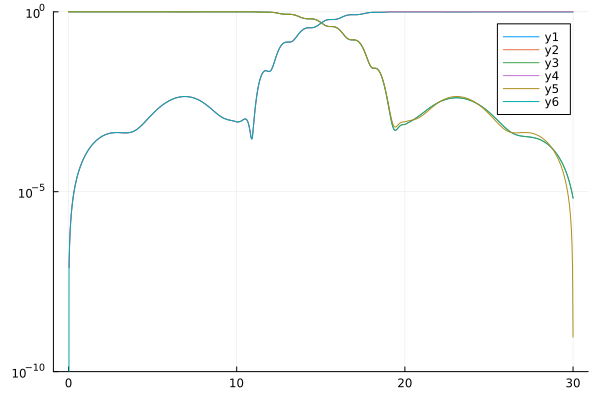

┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots C:\Users\jv97\.julia\packages\Plots\jqILG\src\utils.jl:85
┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots C:\Users\jv97\.julia\packages\Plots\jqILG\src\utils.jl:85
┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots C:\Users\jv97\.julia\packages\Plots\jqILG\src\utils.jl:85


In [77]:
plot(times, [occs,occs2,occs_true], yaxis=:log,ylim=(1e-10,1))

In [ ]:
diag_idxs = diagind(Ua)
function f!(du, u, p, t)
    D = u[:,1]
    Ua = u[:,2:N+1]
    Uv = u[:,N+2:2*N+1]
    x = u[:,2*N+2]
    ψ = u[:,2*N+3]

    tmp = Ua .* dalphadt(p,t)
    
    F =  1 ./ (D .- D')
    F[diag_idxs] .= 0.0
    UddU = F .* tmp

    du[:,1] = real(diag(tmp))
    du[:,2:N+1] = UddU*Ua - Ua*UddU
    du[:,N+2:2*N+1] = UddU*Uv - Uv*UddU
    du[:,2*N+2] = (-im .* (diagm(D) + Uv .* pulse(p,t)) + UddU) * x
    du[:,2*N+3] = (-im .* (diagm(D) + Uv .* pulse(p,t)) + UddU) * ψ